### PINN

Search a space $U\subset L_2$ for the best approximation of solution to Poisson with rhs $f\in L_2$:
$$
    u = \underset{u\in U}{\mathrm{argmin}} ||L u - f||_{L_2}^2 = \underset{u\in U}{\mathrm{argmin}}\: E[u]
$$

For PINN, the idea is to let $U = \{\text{Deep Neural Nets}\}$. 

### Gradient Boosting

In Gradient boosting, we form $u$ as an ensemble of weak estimators:
$$
    u_{k+1} = u_k + \nu_k h_k,\quad \text{where} \quad \nu_k = \underset{\nu\in\mathbb{R}}{\mathrm{argmin}}\: E[u_k + \nu h_k], \quad \text{and} \quad h_k = \underset{h\in H}{\mathrm{argmin}}\:||\nabla_u E[u_k] - h||.
$$
The space of weak estimators $H$ is typically chosen to be regression trees, but the loss $E$ requires $h$ to be differentiable, so we choose shallow neural nets. If $E$ is quadratic as shown above, $\nu_k$ can be obtained as

$$
    \nu_k = -\frac{\langle Lu_k - f\mid Lh_k\rangle }{||Lh_k||^2}
$$


### Energy Natural Gradient Boosting

The idea is almost identical, except that
$$
    h_k = \underset{h\in H}{\mathrm{argmin}}\:||\nabla^E_u E[u_k] - h||,
$$
where $\nabla^E_u \: E[u_k]$ is the Energy Natural Gradient (ENG) of the energy $E$, with respect to the weak estimator space $H$.


### Degradation of gradients
The more steps we take, the more expressive our model, and therefore the gradient will be hard to fit for a weak learner.
One possible solution is soft restarts, where we retrain a smaller model on the ensemble after some number of boosting steps.


In [5]:
from natgrad.domains import Hyperrectangle, RectangleBoundary
from natgrad.inner import model_laplace, model_identity
from natgrad.derivatives import laplace
from natgrad.integrators import RandomIntegrator
from jax import jit, vmap, random, grad
import jax.numpy as jnp
from natgrad.gram import gram_factory, nat_grad_factory
import natgrad.mlp as mlp
import optax
from optax import adam
import jax
import matplotlib.pyplot as plt
from natgrad.plotting import plot_2d_func, remove_axes

jax.config.update("jax_enable_x64", True)

In [6]:
# Define the domain
interior = Hyperrectangle([[0, 1], [0, 1]])
boundary = RectangleBoundary([[0, 1], [0, 1]])

# Integrators
seed = 1
key = random.PRNGKey(seed)
weak_integrator = RandomIntegrator(interior, key, 10000)
interior_integrator = RandomIntegrator(interior, key, 100)
boundary_integrator = RandomIntegrator(boundary, key, 100)
eval_integrator = RandomIntegrator(interior, key, 200)

# random seed
freq = 3.
L = 1.
# solution
@jit
def u_star(xy): return jnp.sin(freq * jnp.pi * xy[0] / L) * jnp.sin(freq * jnp.pi * xy[1] / L)

# rhs
@jit
def f(xy):
    return 2. * (freq * jnp.pi / L)**2 * u_star(xy)

v_u_star = jit(vmap(u_star, 0))
v_f = jit(vmap(f, 0))

In [7]:

# Weak model
layer_sizes = [2, 8, 1]
activation = lambda x : jnp.tanh(x)
model_weak = mlp.mlp(activation)
v_model_weak = jit(vmap(model_weak, (None, 0)))

# Ensemble settings
num_models = 12
num_epochs = 4000 # 8000 # Epochs per weak model

#  Obtain new weights
def init_params(key):
    return mlp.init_params(layer_sizes, key)

# Enseble
def model_ensemble(param, x):
    return sum([w * model_weak(p, x) for (p, w) in param])

model = model_ensemble
v_model = jit(vmap(model, (None, 0)))

# Residual functions
def residual_interior(param, x):
    lap = laplace(lambda x: model(param, x))
    return lap(x) + f(x)

def residual_boundary(param, x):
    return model(param, x) #- u_star(x)

v_res_interior = jit(vmap(lambda param, x: residual_interior(param, x), (None, 0)))
v_res_boundary = jit(vmap(lambda param, x: residual_boundary(param, x), (None, 0)))
   
@jit
def loss(param):
    interior_loss = interior_integrator(lambda x: v_res_interior(param, x) ** 2)
    boundary_loss = boundary_integrator(lambda x: v_res_boundary(param, x) ** 2)
    return interior_loss + boundary_loss


def linearize(x, param, dparam_flat):
    return jax.jvp(lambda param: model(param, x), (param,), (dparam_flat,))[1]

v_linearize = jit(vmap(linearize, (0, None, None)))


# gramians
gram_boundary = gram_factory(model, model_identity, boundary_integrator)
gram_interior = gram_factory(model, model_laplace, interior_integrator)

@jit
def gram(params):
    return gram_interior(params) + gram_boundary(params)

# natural gradient
grad_loss = jit(grad(loss))
nat_grad = nat_grad_factory(gram)

Training initial model


FileNotFoundError: [Errno 2] No such file or directory: '/home/emastr/phd/NaturalGradientTraining/experiments/boosted_learner_0.png'

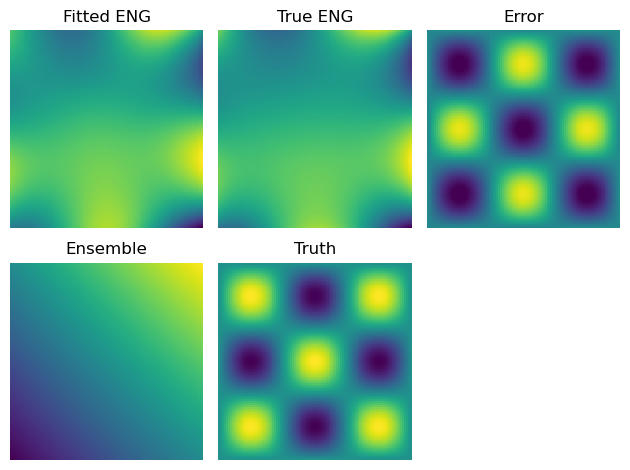

In [8]:
import time

def wrap(func, *args):
    return jit(vmap(lambda x: func(x, *args), (0)))

@jit
def line_search(loss_at_steps, steps):
    losses = loss_at_steps(steps)
    return steps[jnp.argmin(losses)]
#jit(lambda steps, ensemble, weak: steps[jnp.argmin(loss_at_steps(steps, ensemble, weak))])

# Initial training
print("Training initial model")
param = init_params(key)
param_list = [(param, 1.)]
pinn_losses = []
cond_nums = []

for i in range(num_models):
    
    # Obtain training data
    grads = grad_loss(param_list)
    nat_grads = nat_grad(param_list, grads)
    
    grams = gram(param_list)
    cond_nums.append(jnp.linalg.cond(grams))
    # EXPERIMENTAL
    #nat_grads = grads

    x = weak_integrator._x
    y = v_linearize(x, param_list, nat_grads)
    y_norm = jnp.max(jnp.abs(y))
    
    
    x_batches = jnp.array_split(x, 10)
    y_batches = jnp.array_split(y, 10)
        
    @jit
    def loss_weak(param_weak, x_batch, y_batch):
        return jnp.mean((v_model_weak(param_weak, x_batch) - y_batch/y_norm)**2)
    
    
    losses = []
    
    ################### OPTAX ###################
    def fit(param: optax.Params, optimizer: optax.GradientTransformation, num_epochs) -> optax.Params:
        opt_state = optimizer.init(param)

        @jit
        def step(param, opt_state, x_batch, y_batch):
            loss_value, grads = jax.value_and_grad(loss_weak)(param, x_batch, y_batch)
            updates, opt_state = optimizer.update(grads, opt_state, param)
            param = optax.apply_updates(param, updates)
            return param, opt_state, loss_value

        for j in range(num_epochs):
            for b, (x_batch, y_batch) in enumerate(zip(x_batches, y_batches)):
                param, opt_state, loss_value = step(param, opt_state, x_batch, y_batch)
                if b % 20 == 0:
                    losses.append(loss_weak(param, x, y))
                    print(f'Epoch: {j}, batch: {b}, loss: {loss_value:.2e}', end="\r")
        
        return param
    
    # Finally, we can fit our parametrized function using the Adam optimizer provided by optax.
    optimizer = optax.adam(learning_rate=1e-2, b1=0.99, b2=0.99) # b2 = 0.999
    param = fit(init_params(key), optimizer, num_epochs=num_epochs)  
    
    #################################################
    lap_weak = jit(vmap(laplace(lambda x: model_weak(param, x))))
    inner_interior = lambda x: v_res_interior(param_list, x) * lap_weak(x)
    inner_boundary = lambda x: v_res_boundary(param_list, x) * v_model_weak(param, x)
    norm_interior = lambda x: lap_weak(x)**2
    norm_boundary = lambda x: v_model_weak(param, x)**2
    
    weight = -(interior_integrator(inner_interior) + boundary_integrator(inner_boundary)) / \
             (interior_integrator(norm_interior) + boundary_integrator(norm_boundary))
    
    # PLOT
    plt.figure(1)
    ax = plt.subplot(231)
    plt.title("Fitted ENG")
    plot_2d_func(lambda x: v_model_weak(param, x), interior, 100, ax=ax)
    remove_axes(ax)

    ax = plt.subplot(232)
    plt.title("True ENG")
    plot_2d_func(wrap(linearize, param_list, nat_grads), interior, 100, ax=ax)
    remove_axes(ax)
    
    ax = plt.subplot(233)
    plt.title("Error")
    plot_2d_func(lambda x: v_model(param_list, x) - v_u_star(x), interior, 100, ax=ax, vmin=-1, vmax=1)
    remove_axes(ax)
    
    ax = plt.subplot(234)
    plt.title("Ensemble")
    plot_2d_func(lambda x: v_model(param_list, x), interior, 100, ax=ax)
    remove_axes(ax)
    
    ax = plt.subplot(235)
    plt.title("Truth")
    plot_2d_func(lambda x: v_u_star(x), interior, 100, ax=ax)
    remove_axes(ax)
    
    plt.tight_layout()
    plt.gcf().savefig(f"/home/emastr/phd/NaturalGradientTraining/experiments/boosted_learner_{i}.png")
    
    
    ## UPDATE
    param_list = param_list + [(param, weight)]
    pinn_losses.append(loss(param_list))
    
    col = [(0.2 + 0.7*i/num_models), 0.2, (0.8 - 0.7*i/num_models)]
    
    plt.figure(2)
    ax = plt.subplot(131)
    plt.title("Weak learner Loss")
    plt.semilogy(losses, label=f"learner {i}", color=col)
    plt.legend()
    plt.xlabel("Epoch")
    
    ax = plt.subplot(132)
    plt.title("Ensemble pinn loss")
    if i > 0:
        plt.plot([i-1, i], pinn_losses[-2:], '*-', color=col)
    plt.yscale('log')
    plt.xlabel("Weak learner")
    
    ax = plt.subplot(133)
    plt.title("Gram conditioning")
    if i > 0:
        plt.plot([i-1, i], cond_nums[-2:], '*-', color=col)
    plt.yscale('log')
    plt.xlabel("Weak learner")
    
    plt.tight_layout()
    plt.gcf().savefig(f"/home/emastr/phd/NaturalGradientTraining/experiments/boosting_loss.png")
    
    print(f"Weak learner {i}, weak loss: {loss_weak(param, x, y):.2e}, pinn loss = {pinn_losses[-1]:.2e}, weight = {weight:.2e}")


(-0.002512562814070352,
 1.0025125628140703,
 -0.002512562814070352,
 1.0025125628140703)

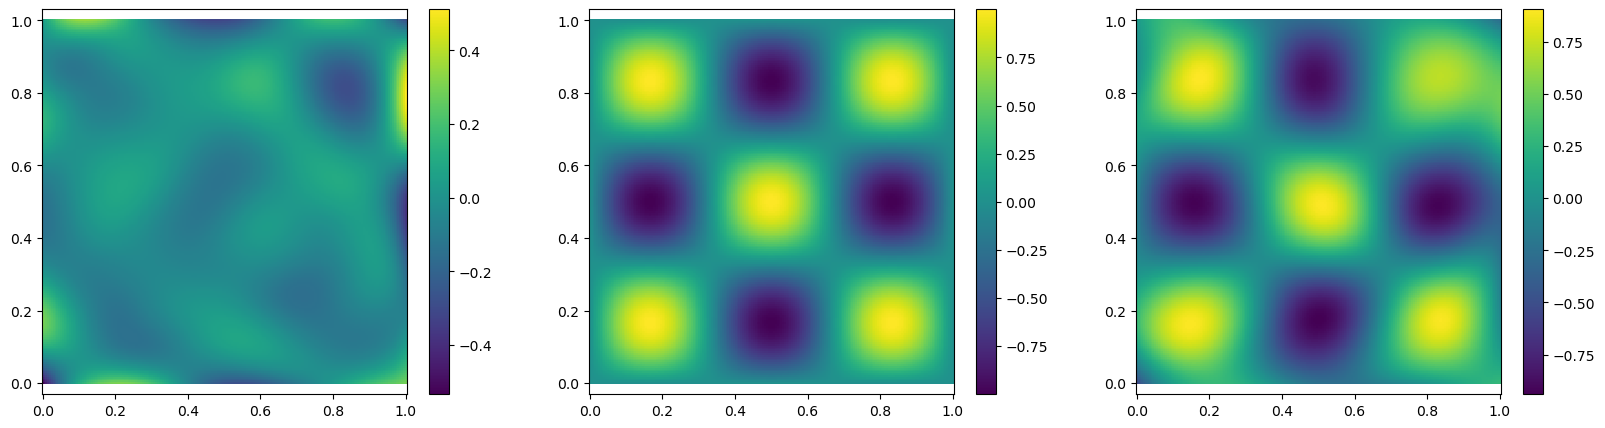

In [ ]:
import matplotlib.pyplot as plt
from natgrad.plotting import plot_2d_func

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
pmesh = plot_2d_func(lambda x: v_model(param_list, x) - v_u_star(x), interior, ax=plt.gca())
plt.colorbar(pmesh)
plt.axis('equal')

plt.subplot(1, 3, 2)
pmesh = plot_2d_func(vmap(u_star, (0)), interior, ax=plt.gca())
plt.colorbar(pmesh)
plt.axis('equal')

plt.subplot(1, 3, 3)
pmesh = plot_2d_func(lambda x: v_model(param_list, x), interior, ax=plt.gca())
plt.colorbar(pmesh)
plt.axis('equal')

In [ ]:
num_steps = 50
# Line search for weights
grid = jnp.arange(-15, 5)
steps = 0.1**grid

def update(param_list, update_list, lr):
    new_param_list = []
    for param, update in zip(param_list, update_list):
        net_pars = [(w - lr*dw, b - lr*db) for (w, b), (dw, db) in zip(param[0], update[0])]
        new_param_list.append((net_pars, param[1]-lr*update[1]))
    return new_param_list

def update_loss(param_list, update_list, lr):
    return loss(update(param_list, update_list, lr))

for i in range(num_steps):
    
    # Obtain training data
    grads = grad_loss(param_list)
    nat_grads = nat_grad(param_list, grads)
    
    step = steps[jnp.argmin(vmap(lambda step: update_loss(param_list, nat_grads, step))(steps))]
    param_list = update(param_list, nat_grads, step)
      
    print(f"Post: step {i}, loss = {loss(param_list):.2e}", end="\r")


(-0.002512562814070352,
 1.0025125628140703,
 -0.002512562814070352,
 1.0025125628140703)

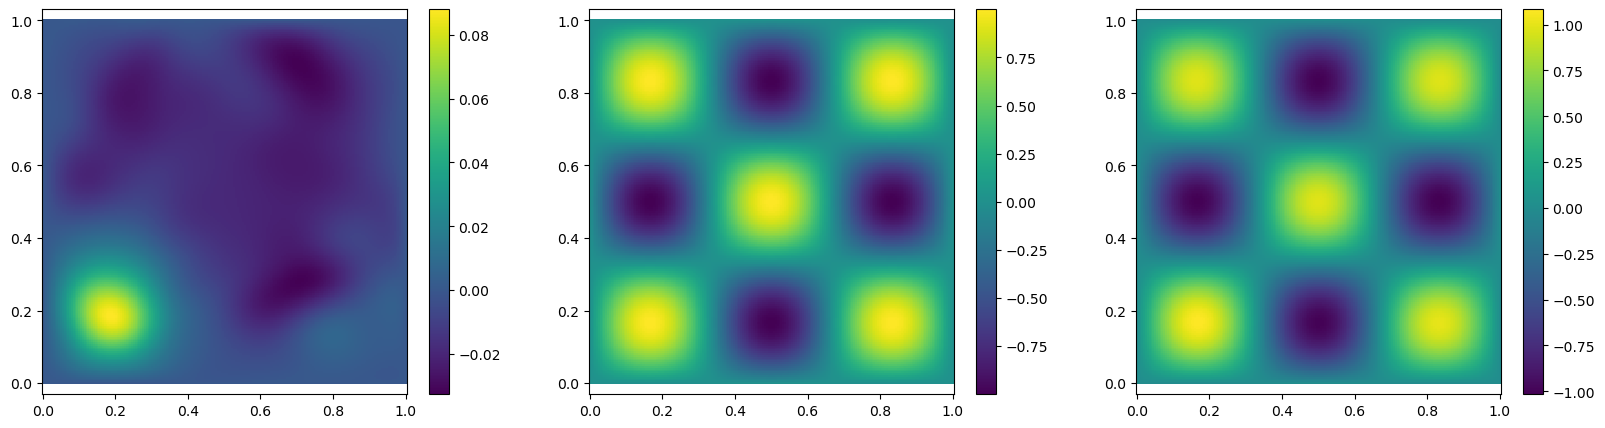

In [ ]:
#param_list = []
#N = 10
# in range(N):
    #key, subkey = random.split(key)
    #param_list.append((init_params(subkey), 1. / N))
    
## Evaluate
#x = weak_integrator._x
#y = v_model(param_list, x)
#y_star = v_u_star(x)

#grads = grad_loss(param_list)
#nat_grads = nat_grad(param_list, grads)
#dy = v_linearize(x, param_list, nat_grads)

#plt.figure()
#plt.scatter(x[:,0],x[:,1], c=-dy)

#plt.figure()
#plt.scatter(x[:,0],x[:,1], c=y_star-y)

#plt.figure()
#plt.scatter(x[:,0],x[:,1], c=y)

#plt.figure()
#plt.scatter(x[:,0],x[:,1], c=y_star)
#v_model_weak(param_list[0][0], interior_integrator._x)

    #for i in range(0):
    # Obtain training data
    #grads = grad_loss(param_list)
    
    #def tmp_loss(step):
   #     param_list_tmp = [([(p - step*dp, w - step * dw) for (p, w), (dp, dw) in zip(param_list[0][0], grads[0][0])], 1.)]
  #      return loss(param_list_tmp)

 #   step = steps[jnp.argmin(vmap(tmp_loss)(steps))]
#    param_list = [([(p-step*dp, w - step * dw) for (p, w), (dp, dw) in zip(param_list[0][0], grads[0][0])], 1.)]

#    print("Epoch: ", i, "Loss: ", loss(param_list), end="\r")
    
    #@jit
    #def loss_weak(param_weak):
    #    return jnp.mean((v_model_weak(param_weak, x) - y/y_norm)**2)
    #grad_loss_weak = jit(grad(loss_weak))
    
    # Initialize parameters
    #param = init_params(key)
    #pinn_loss = loss(param_list)
    
    # Train model against (x, y), standard gradient descent
    
    ################### JAX ###################
    #for j in range(num_epochs):
    #    # Training step
    #    grad_weak = grad_loss_weak(param)
    #    param = [(w - lr * gw, b - lr*gb) for (w, b), (gw, gb) in zip(param, grad_weak)]
    #    print(f"Training weak learner {i}, epoch {j}, weak loss = {loss_weak(param):.2e}, pinn loss = {pinn_loss}", end="\r")
    #    
    #    if j % 100 == 0:
    #        weak_integrator.update()
    ####################
        #line_search_loss = jit(vmap(lambda step: loss(param_list + [(param, -step)])))
    #weight = steps[jnp.argmin(line_search_loss(steps))]
    #param_list = param_list + [(param, -steps[argmin])]
    #print(f'Step idx: {argmin}, size: {steps[argmin]:.2e}')

import matplotlib.pyplot as plt
from natgrad.plotting import plot_2d_func

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
pmesh = plot_2d_func(lambda x: v_model(param_list, x) - v_u_star(x), interior, ax=plt.gca())
plt.colorbar(pmesh)
plt.axis('equal')


plt.subplot(1, 3, 2)
pmesh = plot_2d_func(vmap(u_star, (0)), interior, ax=plt.gca())
plt.colorbar(pmesh)
plt.axis('equal')

plt.subplot(1, 3, 3)
pmesh = plot_2d_func(lambda x: v_model(param_list, x), interior, ax=plt.gca())
plt.colorbar(pmesh)
plt.axis('equal')